In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from scipy.ndimage import distance_transform_edt
from sklearn.isotonic import IsotonicRegression
from scipy.interpolate import make_splrep

## BELL PIECE: FIND SPLINE AND RADII

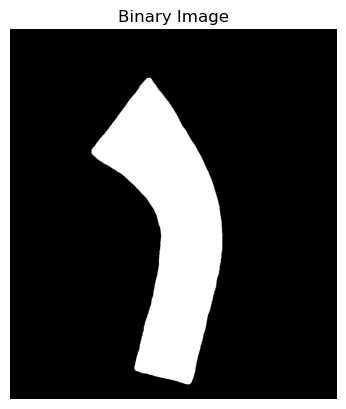

In [3]:
# Load image
image_path = 'angle_corn_ipad.jpg'
image = cv2.imread(image_path)
# Take dimensions
H, W, _ = image.shape

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5, 5), 0)

#Otsu's Thresholding (Automatic threshold based on histogram)
_, binary_otsu = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Removing small dots on the background
# Define a kernel for morphological operations
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (16, 16))

# Apply morphological opening (erosion followed by dilation)
cleaned_image = cv2.morphologyEx(binary_otsu, cv2.MORPH_OPEN, kernel)

# Display result
plt.title('Binary Image')
plt.imshow(cv2.cvtColor(cleaned_image, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.show()

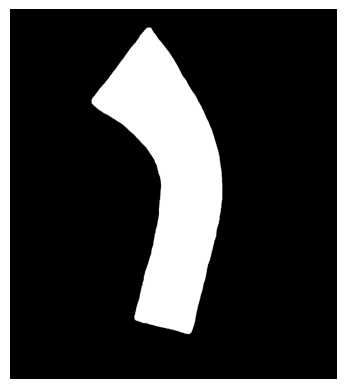

In [4]:
# Define matrix for translation
M = np.float32([[1, 0, 0], [0, 1, -100]])

# Apply the translation to the image (otherwise lower part too close to the border)
translated_img = cv2.warpAffine(cleaned_image, M, (cleaned_image.shape[1], cleaned_image.shape[0]))

# Display the images
plt.imshow(translated_img, cmap='gray')
plt.axis('off')
plt.show()

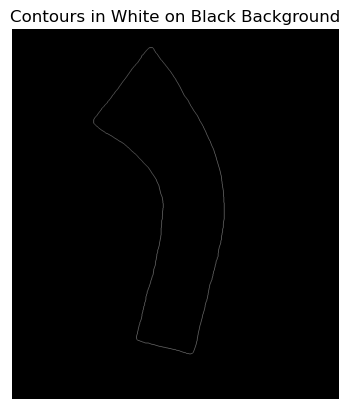

In [5]:
# Extract contour
contours, _ = cv2.findContours(translated_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Contuour as numpy array
contours_np = contours[0]
contours_np = np.squeeze(contours_np, axis=1)

# Create an empty black image, same size as the input
contour_img = np.zeros_like(translated_img)

# Draw contours in white (color=255), thickness=1 (or -1 if you want filled)
cv2.drawContours(contour_img, contours, -1, color=255, thickness=1)

# Show the contour image
plt.imshow(contour_img, cmap='gray')
plt.title('Contours in White on Black Background')
plt.axis('off')
plt.show()

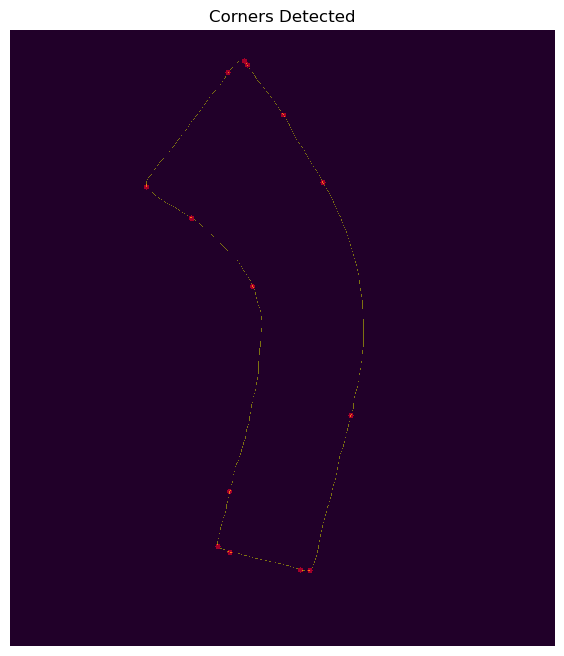

In [6]:
# Detect corners (Shi-Tomasi)
corners = cv2.goodFeaturesToTrack(translated_img, maxCorners=14, qualityLevel=0.01, minDistance=10)

# Convert to integer
corners = np.intp(corners)
corners = np.squeeze(corners, axis=1)

# Create black image to draw corners
corner_img = np.zeros_like(image)

# Draw the corners as white circles
for corner in corners:
    x, y = corner.ravel()
    cv2.circle(corner_img, (x, y), radius=5, color=255, thickness=-1)

# Show the result
plt.figure(figsize=(8, 8))
plt.imshow(corner_img, cmap='gray', interpolation='none')
plt.imshow(contour_img, interpolation='none', alpha=0.5)
plt.title('Corners Detected')
plt.axis('off')
plt.show()

In [7]:
# Find vertices of two extremities of the bell
def midpoints(corners):
    # find two upper corners: the two closest to top left corner
    top_left = np.array([0,0])
    distances = np.linalg.norm(corners - top_left, axis=1)

    indeces_top_vertices = np.argsort(distances)[:4]
    top_vertices = corners[indeces_top_vertices]

    # Get the point with the smallest x-component
    min_x_point = top_vertices[np.argmin(top_vertices[:, 0])]

    # Get the point with the smallest y-component
    min_y_point = top_vertices[np.argmin(top_vertices[:, 1])]

    top_vertices = np.array([min_x_point, min_y_point])



    # find two bottom corners: the two with largest y
    indeces_bottom_vertices = np.argsort(corners[:,1])[-4:]
    bottom_vertices = corners[indeces_bottom_vertices]

    # Get the point with the smallest x-component
    min_x_point = bottom_vertices[np.argmin(bottom_vertices[:, 0])]

    # Get the point with the smallest y-component
    max_x_point = bottom_vertices[np.argmax(bottom_vertices[:, 0])]

    bottom_vertices = np.array([min_x_point, max_x_point])

    return top_vertices, bottom_vertices

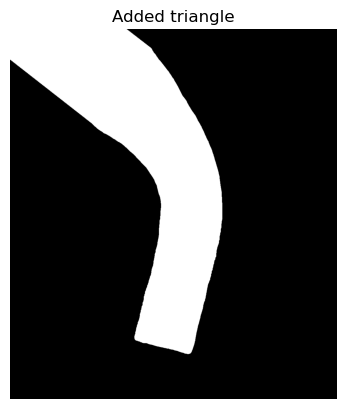

In [8]:
# Extend figure: upper part
top_vertices, bottom_vertices = midpoints(corners)

# Find orientation of upper edge
m_top = (top_vertices[0,1] - top_vertices[1,1]) / (top_vertices[0,0]- top_vertices[1,0])

# Find normal orientation
m_perp_top = - 1/m_top

# Find points on the border for image extension
left_border_x = 0
left_border_y = m_perp_top * (left_border_x - top_vertices[0,0]) + top_vertices[0,1]
p1 = np.array([left_border_x,left_border_y])

right_border_y = 0
right_border_x = top_vertices[1,0] + (right_border_y - top_vertices[1,1]) / m_perp_top
p2 = np.array([right_border_x, right_border_y])

# Define vertices of quad to be filled
upper_triangle_vtx = np.vstack([top_vertices, p2, [0,0], p1])
upper_triangle_vtx = upper_triangle_vtx.astype(np.int32)

# Fill the quad in white
cv2.fillPoly(translated_img, pts=[upper_triangle_vtx], color=(255, 255, 255))

plt.imshow(translated_img, cmap='gray')
plt.title('Added triangle')
plt.axis('off')
plt.show()

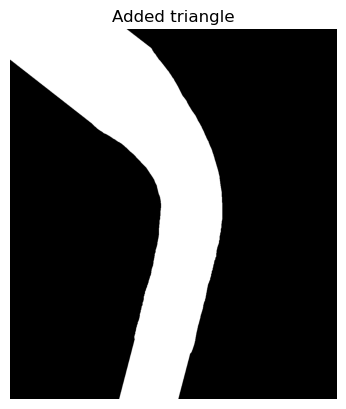

In [9]:
# Same as before for lower edge
m_bot = (bottom_vertices[0,1] - bottom_vertices[1,1]) / (bottom_vertices[0,0]- bottom_vertices[1,0])

m_perp_bot = - 1/m_bot

left_border_y = 1218
left_border_x = bottom_vertices[0,0] + (left_border_y - bottom_vertices[0,1]) / m_perp_bot
p1 = np.array([left_border_x, left_border_y])

right_border_y = 1218
right_border_x = bottom_vertices[1,0] + (right_border_y - bottom_vertices[1,1]) / m_perp_bot
p2 = np.array([right_border_x, right_border_y])

lower_quad_vtx = np.vstack([bottom_vertices, p2, p1])
lower_quad_vtx = lower_quad_vtx.astype(np.int32)

# Fill the triangle in white
cv2.fillPoly(translated_img, pts=[lower_quad_vtx], color=(255, 255, 255))

plt.imshow(translated_img, cmap='gray')
plt.title('Added triangle')
plt.axis('off')
plt.show()

(1387, 3)


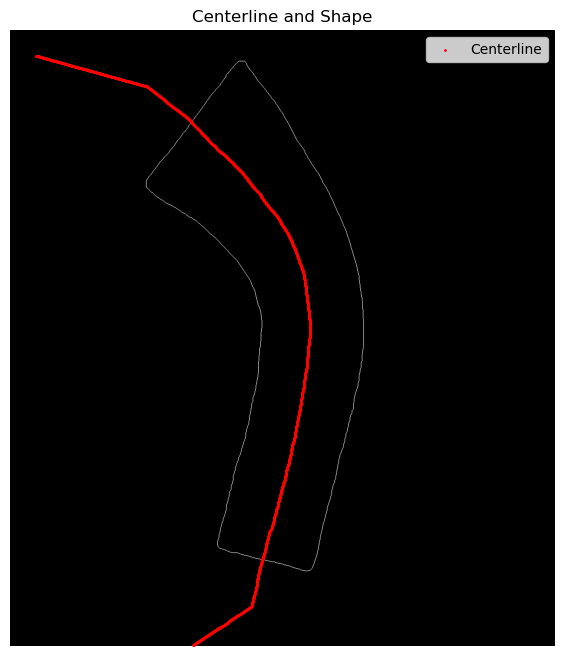

In [10]:
# Now skeletonize for obtaining spline
# Skeletonize the image (convert to boolean first for skimage)
skeleton = skeletonize(translated_img > 0)

# Convert skeleton from boolean to int values (to be used by openCV)
skeleton = (skeleton * 255).astype(np.uint8)

# Compute the distance transform (from background to object interior)
distance_transform = distance_transform_edt(translated_img)

# For each skeleton point, get its radius from distance transform
skeleton_points = np.column_stack(np.where(skeleton))

# Extract coordinates and corresponding radius values
centerline_coords = []
radii = []

for y, x in skeleton_points:
    radius = distance_transform[y, x]
    centerline_coords.append((x, y))
    radii.append(radius)

# Convert to numpy arrays for easier processing later
centerline_coords = np.array(centerline_coords)
radii = np.array(radii)

# Merge the informations
center_and_radii = np.hstack((centerline_coords, radii.reshape(-1,1)))
print(center_and_radii.shape)

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(contour_img, cmap='gray')
plt.scatter(centerline_coords[:, 0], centerline_coords[:, 1], color='red', s=1, label='Centerline')
plt.title('Centerline and Shape')
plt.legend()
plt.axis('off')
plt.show()

In [11]:
# I want to remove spline parts outside of shape

# Convert arrays to tuples for set operations
arr1_tuples = [tuple(point) for point in centerline_coords]
arr2_tuples = [tuple(point) for point in contours_np]

# Find the shared points (intersection)
shared_points_tuples = set(arr1_tuples) & set(arr2_tuples)

# Convert the shared points back to a NumPy array
shared_points = np.array(list(shared_points_tuples))
print(shared_points)

[[ 359  182]
 [ 499 1048]]


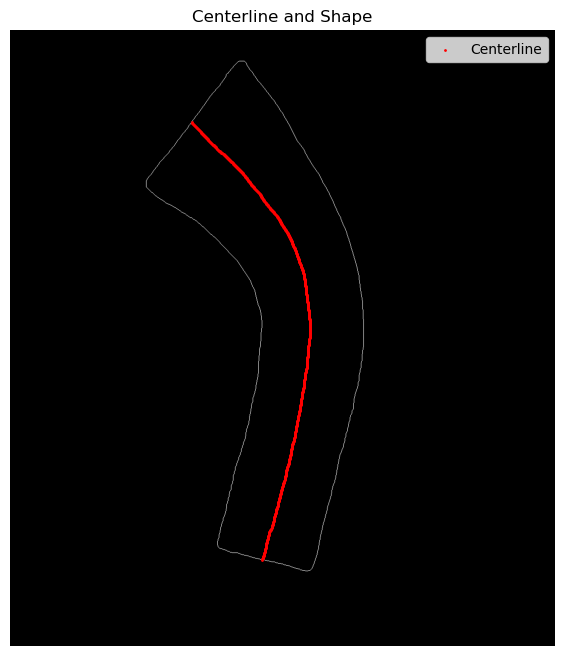

In [12]:
# Remove undesired points from the centerline
center_and_radii = center_and_radii[center_and_radii[:,1] <= shared_points[1,1]]
center_and_radii = center_and_radii[center_and_radii[:,1] >= shared_points[0,1]]

# Visualization
plt.figure(figsize=(8, 8))
plt.imshow(contour_img, cmap='gray')
plt.scatter(center_and_radii[:, 0], center_and_radii[:, 1], color='red', s=1, label='Centerline')
plt.title('Centerline and Shape')
plt.legend()
plt.axis('off')
plt.show()

In [13]:
# Find angle for rotation
#theta = np.arctan2(bottom_vertices[0,1]-bottom_vertices[1,1], bottom_vertices[0,0]-bottom_vertices[1,0])
theta = np.arctan2(center_and_radii[-1, 1]-center_and_radii[-60, 1], center_and_radii[-1, 0]-center_and_radii[-60, 0])
center = [W/2, H/2]

# Rotation matrix using OpenCV
#M = cv2.getRotationMatrix2D(center, 90+np.degrees(theta), 1)
M = cv2.getRotationMatrix2D(center, 180+np.degrees(theta), 1)

centers_only = center_and_radii[:,:2]
centers_only = centers_only.reshape((-1,1,2))

# Apply the rotation matrix to the points
rotated_points = cv2.transform(centers_only, M)

rotated_points = np.squeeze(rotated_points, axis=1)

rotated_points = rotated_points.astype('int32')


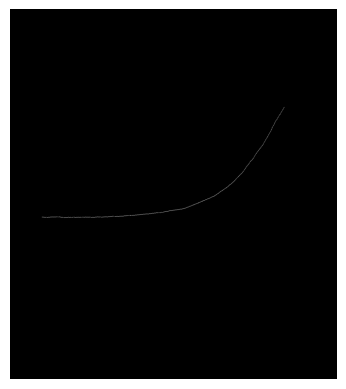

In [14]:
# Define image size (for example, 500x500 image)
img_size = (H,W)

# Create a black image (background)
image = np.zeros(img_size, dtype=np.uint8)

# Set the pixels corresponding to the rotated points to 1
for point in rotated_points:
    x, y = point
    if 0 <= x < img_size[1] and 0 <= y < img_size[0]:  # Check if point is within bounds
        image[y, x] = 1  # Set the pixel value to 1

# Display the image using Matplotlib (useful for inline Jupyter display)
plt.imshow(image, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()

In [15]:
# Inspect the coordinated of the leftest point
initial_point = rotated_points[np.argmin(rotated_points[:,0]),:]

# Translate in the origin wrt this point
rotated_points -= initial_point

# Take y values in the correct direction
rotated_points[:,1] = -rotated_points[:,1]

# Final data
center_and_radii[:,:2] = rotated_points

# Insert z-coordinate
center_and_radii = np.insert(center_and_radii, 2, 0, axis=1)

## BELL PIECE: FIND PROPORTIONS

In [16]:
# Find real proportions:
length_axis = 0

for i in range(1,len(center_and_radii)):
    dist = np.linalg.norm(center_and_radii[i,:2]-center_and_radii[i-1,:2])
    length_axis += dist

diameter_bottom = center_and_radii[-1,3]*2
diameter_top = center_and_radii[0,3]*2
#diameter_bottom2 = np.linalg.norm(bottom_vertices[0]-bottom_vertices[1])

print(length_axis)
print(diameter_bottom)
print(diameter_top)
#print(diameter_bottom2)

1082.4250009488744
184.83506160899236
310.0


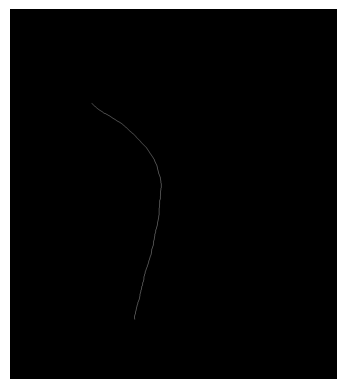

In [17]:
# Extract short edge (the one for which I have the measures)
short_edge = contours_np[contours_np[:,1] >= top_vertices[0,1]]
short_edge = short_edge[short_edge[:,1] <= bottom_vertices[0,1]]
short_edge = short_edge[short_edge[:,0] <= bottom_vertices[1,0]]

# Visualize to check
# Define image size (for example, 500x500 image)
img_size = (H,W)

# Create a black image (background)
image = np.zeros(img_size, dtype=np.uint8)

# Set the pixels corresponding to the rotated points to 1
for point in short_edge:
    x, y = point
    if 0 <= x < img_size[1] and 0 <= y < img_size[0]:  # Check if point is within bounds
        image[y, x] = 1  # Set the pixel value to 1

# Display the image using Matplotlib (useful for inline Jupyter display)
plt.imshow(image, cmap='gray')
plt.axis('off')  # Hide axis
plt.show()


In [18]:
# Calculate length
length_edge = 0

for i in range(1,len(short_edge)):
    dist = np.linalg.norm(short_edge[i,:]-short_edge[i-1,:])
    length_edge += dist

print(length_edge)

864.8082245892151


In [19]:
# Rescale to match real sizes (123: real value in mm)
scale_factor = 555/length_edge
center_and_radii_rescaled = scale_factor * center_and_radii

# Remove first 20 mm (THIS SHOULD BE FINE: they are for fixing other part)
final_bell = center_and_radii_rescaled[center_and_radii_rescaled[:,0] >= 20]
# Flip its row to coherent attach with other data
final_bell = final_bell[::-1]
# Translate so that shape starts in the origin
final_bell[:,:2] -= final_bell[0,:2]
# Inspect radius of smaller edge
print(final_bell[0,:])

# Remove 10 mm to the radius: radii adjusted to match interior (they are now radii of exterior)
final_bell[:,3] -= 10
print(final_bell[0,:])

# Remove oscillations on y-coordinate for the first part (after visual inspection, I decided bend starts at index 178)
final_bell[:178,1] = 0

[ 0.          0.          0.         61.48188844]
[ 0.          0.          0.         51.48188844]


In [20]:
# Remove duplicates of the x-coordinate
xi = final_bell[:,0]
# Use np.unique with return_index to get first occurrences
_, idx_first_occurrence = np.unique(xi, return_index=True)

# Sort indices to preserve the original order
idx_first_occurrence_sorted = np.sort(idx_first_occurrence)

# Get the filtered array
final_bell = final_bell[idx_first_occurrence_sorted]

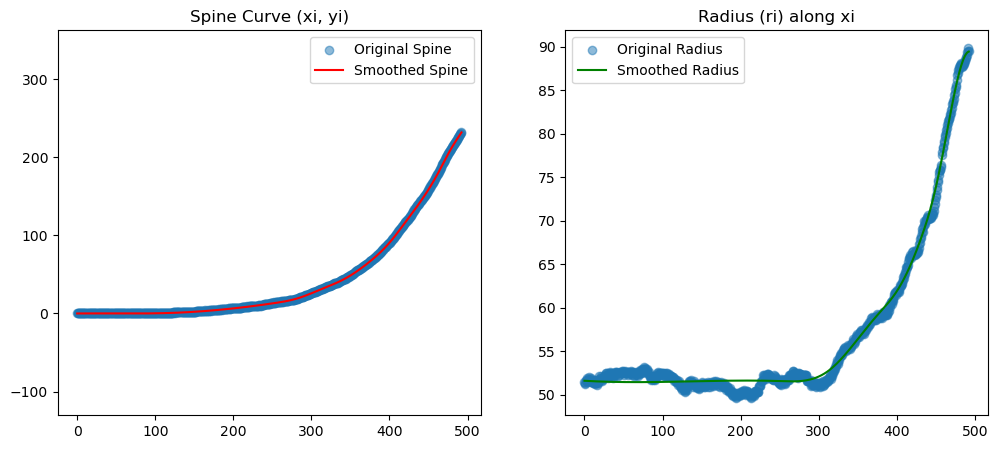

In [21]:
# Remove noise for y-coord and radii for image acquired data: impose monotonicity and smoothness
xi = final_bell[:,0]
yi = final_bell[:,1]
ri = final_bell[:,3]

# Force arrays to be contiguous (for make_splrep)
xi = np.ascontiguousarray(xi)
yi = np.ascontiguousarray(yi)
ri = np.ascontiguousarray(ri)

# Isotonic regression (monotonic increasing)
iso_reg_y = IsotonicRegression(increasing=True)
yi_smooth = iso_reg_y.fit_transform(xi, yi)

# Isotonic regression for radius
iso_reg_r = IsotonicRegression(increasing=True)
ri_smooth = iso_reg_r.fit_transform(xi, ri)

# Calculate spline
spl_y = make_splrep(xi, yi_smooth, s=100)
spl_r = make_splrep(xi, ri_smooth, s=100)

# Extract control points
xx = np.linspace(np.min(xi), np.max(xi), 400)
yi_fine = spl_y(xx)
ri_fine = spl_r(xx)

# Subsitute values
final_bell = np.stack((xx, yi_fine, ri_fine), axis=1)
# Insert z-coordinate
final_bell = np.insert(final_bell, 2, 0, axis=1)


#Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
# Spine curve
axs[0].scatter(xi, yi, label='Original Spine', alpha=0.5)
axs[0].plot(xx, yi_fine, color='red', label='Smoothed Spine')
axs[0].set_title('Spine Curve (xi, yi)')
axs[0].legend()
axs[0].axis('equal')
# Radius profile
axs[1].scatter(xi, ri, label='Original Radius', alpha=0.5)
axs[1].plot(xx, ri_fine, color='green', label='Smoothed Radius')
axs[1].set_title('Radius (ri) along xi')
axs[1].legend()

plt.show()

In [22]:
# I have to impose again horizontal spline up to index 178
final_bell[:178,1] = 0

In [23]:
# I impose monotonicity of the radius: if radius decreases, I impose it equal to previous point

for i in range(final_bell.shape[0]-1):
    if final_bell[i+1, 3] < final_bell[i,3]:
        final_bell[i+1,3] = final_bell[i,3]

In [32]:
# Save final_bell in CSV file with header (remark: its x-spline values start with 0, it will be needed to translate properly)
column_names = ['x-spline', 'y-spline', 'z-spline', 'radius']

np.savetxt("final_bell.csv", final_bell, delimiter=",", header="x-spline, y-spline, z-spline, radius", comments='', fmt="%.3f")

## MOUTHPIECE: NON-LINEAR PART

In [28]:
# Non-linear part of mouthpiece (mouth extremity): photo with iPad and zoom + calco foglio
mouthpiece_radii = np.array([9.5, 9.47, 9.2, 8.68, 8.42, 7.9, 7.1, 6.84, 5.79, 5, 3.95, 3.16, 2.37])
mouthpiece_x = np.arange(0, 24 + 0.01, 2)
mouthpiece_0 = np.stack((mouthpiece_x, mouthpiece_radii), axis=1)
y_z = np.zeros([mouthpiece_0.shape[0],2])
mouthpiece_0 = np.insert(mouthpiece_0, 1, y_z.T, axis=1)

In [29]:
# Function that gives back coordinates and radii for a conical piece
def conical_mesh(left_rad, right_rad, length, x_initial, tau):
    m = (right_rad - left_rad) / length
    xx = np.arange(0, length, tau)
    radii = m*xx + left_rad
    xx += x_initial
    xx_and_radii = np.column_stack((xx, radii))
    
    y_z = np.zeros([xx_and_radii.shape[0],2])
    coord_and_radii = np.insert(xx_and_radii, 1, y_z.T, axis=1)

    return coord_and_radii

In [30]:
# Conical parts (using measurements by artisan)
# Set discretization step
tau = 2
# Use function
mouthpiece_1 = conical_mesh(2.5, 5, 55, 25, tau)
mouthpiece_2 = conical_mesh(5, 6, 30, 80, tau)

In [31]:
mouthpiece = np.concatenate((mouthpiece_0,mouthpiece_1,mouthpiece_2), axis=0)

In [33]:
# Save mouthpiece in CSV file with header
column_names = ['x-spline', 'y-spline', 'z-spline', 'radius']

np.savetxt("mouthpiece.csv", mouthpiece, delimiter=",", header="x-spline, y-spline, z-spline, radius", comments='', fmt="%.3f")

## CONICAL PARTS

In [ ]:
# Set discretization step
tau = 2

initial_point = 110
cone_1_28 = conical_mesh(6.5, 13.5, 560, initial_point, tau)
cone_1_33 = conical_mesh(6.5, 16, 560, initial_point, tau)
initial_point += 560
# SMALLER CAN BE 28 OR 33!!!!
cone_2_28 = conical_mesh(14, 28.5, 925, initial_point, tau)
cone_2_33 = conical_mesh(16.5, 28.5, 925, initial_point, tau)
initial_point += 925
cone_3 = conical_mesh(29, 44, 825, initial_point, tau)
initial_point += 825
cone_4 = conical_mesh(44.5, 51, 465, initial_point, tau)
initial_point += 465

# Set right x-value for final part
final_bell[:,0] += initial_point

In [573]:
# Concatenate data in final dataset
mesh_data_28 = np.concatenate((mouthpiece_0,mouthpiece_1,mouthpiece_2,cone_1_28,cone_2_28,cone_3,cone_4,final_bell), axis=0)
mesh_data_33 = np.concatenate((mouthpiece_0,mouthpiece_1,mouthpiece_2,cone_1_33,cone_2_33,cone_3,cone_4,final_bell), axis=0)

In [574]:
# Save in CSV file with header
column_names = ['x-spline', 'y-spline', 'z-spline', 'radius']

# Convert to DataFrame with headers
df_28 = pd.DataFrame(mesh_data_28, columns=column_names)
df_33 = pd.DataFrame(mesh_data_33, columns=column_names)

# Save to CSV with headers
df_28.to_csv('alphorn_spline_radii_28.csv', index=False, float_format='%.3f')
df_33.to_csv('alphorn_spline_radii_33.csv', index=False, float_format='%.3f')